In [4]:
import os # ADDED THIS LINE
os.environ['JAX_PLATFORMS'] = 'cpu' # ADDED THIS LINE

import jax
import jax.numpy as jnp
from flax.training import train_state
import optax
import mujoco
from mujoco import mjx
from typing import Callable, Dict
from jax import Array

# from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sysidmjx.core import generate_loss_train_functions, get_batch
from sysidmjx.assets.single_motor.dataloader.single_joint import data_load
from jax import config

from datetime import datetime

current_time = datetime.now()

config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_matmul_precision", "high")


class PARAMS:
    SEED = jax.random.PRNGKey(42)
    EXPERIMENT_NAME = f"exo_optimization_try_{current_time.strftime('%Y%m%d_%H%M')}"

    class DATASET:
        PATH = "data/exo_data2_07_04_copy.csv"
        DT = 0.02  # After 20x downsampling: 1000Hz -> 50Hz = 0.02s timestep
        MAX_SAMPLES = 100000  # Limit dataset size to avoid memory issues

    class SIM:
        PATH = "exo.xml"
        INTEGRATOR = mujoco.mjtIntegrator.mjINT_EULER
        ITERATIONS = 5  # Match your XML

    class TRAIN:
        EPOCH_NUM = 100  # Many epochs for overnight training
        BATCH_SIZE = 100  # Smaller batches due to large dataset
        INITIAL_LEARNING_RATE = 0.01  # Moderate learning rate
        MIN_LEARNING_RATE = 1e-5
        PATIENCE = 20  # Stop if no improvement for 20 epochs
        SAVE_EVERY = 100  # Save checkpoint every 100 epochs
        TRAJECTORY_LENGTH = 200 # Use 200 timesteps ( 4s at 50Hz)

        # Cosine decay schedule
        @staticmethod
        def get_optimizer(num_epochs):
            schedule = optax.cosine_decay_schedule(
                init_value=PARAMS.TRAIN.INITIAL_LEARNING_RATE,
                decay_steps=num_epochs,
                alpha=PARAMS.TRAIN.MIN_LEARNING_RATE / PARAMS.TRAIN.INITIAL_LEARNING_RATE
            )
            return optax.adam(schedule)
        
        TX = None  # Will be set in training loop

# Joint names matching your actuators (10 joints)
JOINT_NAMES = [
    'left_hip_aa', 'left_hip_fe', 'left_knee', 
    'L_Front_Linear', 'L_Back_Linear',
    'right_hip_aa', 'right_hip_fe', 'right_knee',
    'R_Front_Linear', 'R_Back_Linear'
]

    # class MODEL:
    #     NUM_HIST_LAGS = 5

In [5]:
# # Add this cell BEFORE loading data to find correct indices
# import mujoco

# # Load the model
# m = mujoco.MjModel.from_xml_path(PARAMS.SIM.PATH)

# print(f"Total qpos DOF: {m.nq}")
# print(f"Total qvel DOF: {m.nv}")
# print(f"Number of actuators: {m.nu}")

# print("\n=== JOINT INFORMATION ===")
# print(f"Total joints: {m.njnt}")

# # Map joint names to qpos/qvel indices
# joint_qpos_idx = {}
# joint_qvel_idx = {}

# for i in range(m.njnt):
#     joint_name = m.joint(i).name
#     qpos_adr = m.jnt_qposadr[i]
#     qvel_adr = m.jnt_dofadr[i]
    
#     print(f"\nJoint {i}: {joint_name}")
#     print(f"  qpos address: {qpos_adr}")
#     print(f"  qvel address: {qvel_adr}")
#     print(f"  type: {m.jnt_type[i]}")
    
#     joint_qpos_idx[joint_name] = qpos_adr
#     joint_qvel_idx[joint_name] = qvel_adr

# print("\n=== ACTUATOR INFORMATION ===")
# for i in range(m.nu):
#     actuator_name = m.actuator(i).name
#     print(f"Actuator {i}: {actuator_name}")

# # Now map your JOINT_NAMES to the correct indices
# print("\n=== MAPPING FOR YOUR ACTUATED JOINTS ===")

# # Your actuated joints (motors from XML)
# MOTOR_NAMES = [
#     'left_hip_aa', 'left_hip_fe', 'left_knee',
#     'L_Front_Linear', 'L_Back_Linear',
#     'right_hip_aa', 'right_hip_fe', 'right_knee',
#     'R_Front_Linear', 'R_Back_Linear'
# ]

# # The actual JOINT names (not motor names!)
# JOINT_MAPPING = {
#     'left_hip_aa': 'left_hip_aa',
#     'left_hip_fe': 'left_hip_fe', 
#     'left_knee': 'left_knee',
#     'L_Front_Linear': 'L_Front_Motor',  # Motor acts on this joint
#     'L_Back_Linear': 'L_Back_Motor',
#     'right_hip_aa': 'right_hip_aa',
#     'right_hip_fe': 'right_hip_fe',
#     'right_knee': 'right_knee',
#     'R_Front_Linear': 'R_Front_Motor',
#     'R_Back_Linear': 'R_Back_Motor'
# }

# ACTUATED_QPOS_IDX = []
# ACTUATED_QVEL_IDX = []

# for motor_name in MOTOR_NAMES:
#     joint_name = JOINT_MAPPING.get(motor_name, motor_name)
    
#     if joint_name in joint_qpos_idx:
#         qpos_idx = joint_qpos_idx[joint_name]
#         qvel_idx = joint_qvel_idx[joint_name]
        
#         ACTUATED_QPOS_IDX.append(qpos_idx)
#         ACTUATED_QVEL_IDX.append(qvel_idx)
        
#         print(f"{motor_name:20s} -> Joint: {joint_name:20s} | qpos[{qpos_idx:2d}] qvel[{qvel_idx:2d}]")
#     else:
#         print(f"WARNING: Could not find joint '{joint_name}' for motor '{motor_name}'")

# print(f"\nACTUATED_QPOS_IDX = {ACTUATED_QPOS_IDX}")
# print(f"ACTUATED_QVEL_IDX = {ACTUATED_QVEL_IDX}")

# Load Exoskeleton Data

In [6]:
def load_exo_data(csv_path, max_samples=None, downsample_factor=20, trajectory_length=5):
    """Load exoskeleton data from CSV and prepare for simulation."""
    df = pd.read_csv(csv_path)
    
    # Downsample to reduce timestep (1000Hz -> 50Hz by default)
    if downsample_factor > 1:
        print(f"Downsampling data by factor {downsample_factor} (1000Hz -> {1000/downsample_factor:.0f}Hz)")
        df = df.iloc[::downsample_factor].reset_index(drop=True)
    
    # Limit dataset size if specified
    if max_samples is not None and len(df) > max_samples:
        print(f"Limiting dataset from {len(df)} to {max_samples} samples")
        df = df.iloc[:max_samples].copy()
    
    n_samples_raw = len(df)
    n_joints = len(JOINT_NAMES)
    
    # Load actuated joint data from CSV
    qpos_actuated = np.zeros((n_samples_raw, n_joints))
    qvel_actuated = np.zeros((n_samples_raw, n_joints))
    qctrl_raw = np.zeros((n_samples_raw, n_joints))
    
    for i, joint in enumerate(JOINT_NAMES):
        qpos_actuated[:, i] = df[f'{joint}_pos'].values
        qvel_actuated[:, i] = df[f'{joint}_vel'].values
        qctrl_raw[:, i] = df[f'{joint}_torque'].values
    
    # Convert linear actuator positions from mm to meters
    linear_actuator_indices = [3, 4, 8, 9]
    for idx in linear_actuator_indices:
        qpos_actuated[:, idx] = (qpos_actuated[:, idx] - 40.0) / 1000.0
        qvel_actuated[:, idx] = qvel_actuated[:, idx] / 1000.0  # mm/s to m/s
    
    # Check for NaN or inf values
    if np.any(~np.isfinite(qpos_actuated)) or np.any(~np.isfinite(qvel_actuated)) or np.any(~np.isfinite(qctrl_raw)):
        print("WARNING: Non-finite values detected in raw data!")

    # Create rolling windows for trajectories
    num_windows = n_samples_raw - trajectory_length
    qpos_windows = np.array([qpos_actuated[i] for i in range(num_windows)])
    qvel_windows = np.array([qvel_actuated[i] for i in range(num_windows)])
    qctrl_windows = np.array([qctrl_raw[i : i + trajectory_length] for i in range(num_windows)])
    qpos_next_windows = np.array([qpos_actuated[i + 1 : i + 1 + trajectory_length] for i in range(num_windows)])
    qvel_next_windows = np.array([qvel_actuated[i + 1 : i + 1 + trajectory_length] for i in range(num_windows)])

    # Load model to get full DOF dimensions
    m = mujoco.MjModel.from_xml_path(PARAMS.SIM.PATH)
    nq_full, nv_full = m.nq, m.nv
    
    # Create full qpos and qvel arrays
    qpos_full = np.tile(m.qpos0, (num_windows, 1))
    qvel_full = np.zeros((num_windows, nv_full))
    
    # Map actuated joint data to correct indices
    actuated_qpos_idx = [0, 1, 2, 4, 7, 11, 12, 13, 15, 18]
    actuated_qvel_idx = [0, 1, 2, 4, 7, 11, 12, 13, 15, 18]
    
    
    for i in range(n_joints):
        qpos_full[:, actuated_qpos_idx[i]] = qpos_windows[:, i]
        qvel_full[:, actuated_qvel_idx[i]] = qvel_windows[:, i]

    dataset = {
        'qpos': jnp.array(qpos_full),
        'qvel': jnp.array(qvel_full),
        'qact': jnp.array(qctrl_windows),
        'qpos_next': jnp.array(qpos_next_windows),
        'qvel_next': jnp.array(qvel_next_windows)
    }
    
    return dataset, df

dataset, df = load_exo_data(
    PARAMS.DATASET.PATH, 
    max_samples=PARAMS.DATASET.MAX_SAMPLES, 
    downsample_factor=20,
    trajectory_length=PARAMS.TRAIN.TRAJECTORY_LENGTH
)

print(f"\nDataset loaded: {dataset['qpos'].shape[0]} samples (windows)")
print(f"  Full qpos shape: {dataset['qpos'].shape}")
print(f"  Full qvel shape: {dataset['qvel'].shape}")
print(f"  Control shape (qact): {dataset['qact'].shape} -> (samples, trajectory, joints)")
print(f"  Target shape (qpos_next): {dataset['qpos_next'].shape} -> (samples, trajectory, joints)")


Downsampling data by factor 20 (1000Hz -> 50Hz)

Dataset loaded: 12800 samples (windows)
  Full qpos shape: (12800, 22)
  Full qvel shape: (12800, 22)
  Control shape (qact): (12800, 200, 10) -> (samples, trajectory, joints)
  Target shape (qpos_next): (12800, 200, 10) -> (samples, trajectory, joints)


# Setup model

In [7]:
mj_model = mujoco.MjModel.from_xml_path(PARAMS.SIM.PATH)
mj_model.opt.timestep = PARAMS.DATASET.DT
mj_model.opt.iterations = PARAMS.SIM.ITERATIONS
mj_model.opt.integrator = PARAMS.SIM.INTEGRATOR

# CRITICAL: Disable contacts/constraints to allow gradient computation
# MuJoCo's constraint solver uses while_loop which doesn't support reverse-mode autodiff
mj_model.opt.disableflags = mj_model.opt.disableflags | mujoco.mjtDisableBit.mjDSBL_CONSTRAINT

mj_data = mujoco.MjData(mj_model)

mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)
print(f"integrator:{mj_model.opt.integrator}")
print(f"timestep:{mj_model.opt.timestep}")
print(f"iterations:{mj_model.opt.iterations}")
print(f"constraints disabled: {bool(mj_model.opt.disableflags & mujoco.mjtDisableBit.mjDSBL_CONSTRAINT)}")

integrator:0
timestep:0.02
iterations:5
constraints disabled: True


# Identify parameters and function they use

In [8]:
# Get number of joints and DOF structure
n_joints = len(JOINT_NAMES)
n_dof_total = mjx_model.nv
n_actuators = mjx_model.nu

# Indices of actuated joints in the full qpos/qvel arrays
# Order matches JOINT_NAMES: left_hip_aa, left_hip_fe, left_knee, L_Front_Slide, L_Back_Slide,
#                             right_hip_aa, right_hip_fe, right_knee, R_Front_Slide, R_Back_Slide
ACTUATED_QPOS_IDX = jnp.array([0, 1, 2, 4, 10, 17, 18, 19, 21, 27])
ACTUATED_QVEL_IDX = jnp.array([0, 1, 2, 4, 9, 15, 16, 17, 19, 24])

# Use 5 timesteps (100ms at 50Hz) - balance between effect accumulation and computation
TRAJECTORY_LENGTH = 5

print(f"Number of actuated joints: {n_joints}")
print(f"Number of actuators in model: {n_actuators}")
print(f"Total qpos DOF: {mjx_model.nq}, Total qvel DOF: {n_dof_total}")
print(f"Actuated qpos indices: {ACTUATED_QPOS_IDX}")
print(f"Joint names: {JOINT_NAMES}")
print(f"Trajectory length: {TRAJECTORY_LENGTH} steps ({TRAJECTORY_LENGTH * PARAMS.DATASET.DT * 1000:.0f} ms)")

# Generate random keys for initialization
keys = jax.random.split(PARAMS.SEED, num=3)

# Define initial parameters for the model (set to zeros initially)
zero_params = {
    "armature": jnp.array([5, 3.66, 3.66, 5, 5, 5, 3.66, 3.66, 5, 5]),
    # "armature": jnp.array([5, 5, 5, 5, 5, 5]),
    "damping": jnp.array([5, 2, 2, 5, 5, 5, 2, 2, 5, 5]),
    "frictionloss": jnp.array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10]),
}

# Define initial parameters - based on your XML defaults
init_params = {
    "armature": jnp.array([5, 3.66, 3.66, 5, 5, 5, 3.66, 3.66, 5, 5], dtype=jnp.float32),
    "damping": jnp.array([5, 2, 2, 5, 5, 5, 2, 2, 5, 5], dtype=jnp.float32),
    "frictionloss": jnp.array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=jnp.float32),
    # "armature": jax.random.uniform(keys[2], minval=1.0, maxval=10, shape=(n_joints,)),
    # "damping": jax.random.uniform(keys[2], minval=0.001, maxval=5, shape=(n_joints,)),
    # "frictionloss": jax.random.uniform(keys[2], minval=0.001, maxval=10, shape=(n_joints,)),
}


@jax.jit
def change_model(params: Dict, old_model: mjx.Model):

    full_armature = old_model.dof_armature.at[ACTUATED_QVEL_IDX].set(jnp.abs(params["armature"]))

    full_damping = old_model.dof_damping.at[ACTUATED_QVEL_IDX].set(jnp.abs(params["damping"]))
    full_frictionloss = old_model.dof_frictionloss.at[ACTUATED_QVEL_IDX].set(jnp.abs(params["frictionloss"]))

    changed_model = old_model.replace(
        dof_armature=full_armature,
        dof_damping=full_damping,
        dof_frictionloss=full_frictionloss,
    )

    return changed_model


@jax.jit
def make_action(params:Dict, data:mjx.Data, ctrl:Array):
    """Direct torque passthrough."""
    return ctrl


# Custom loss function that only compares actuated joint positions
@jax.jit
def predict_next_actuated(params, qpos0_full, qvel0_full, ctrl_vec):
    """Predict trajectory and extract only actuated joint positions."""
    sim_model = change_model(params, mjx_model)
    
    def body(carry, ctrl_t):
        qpos, qvel = carry
        # Reconstruct data with current state
        data = mjx_data.replace(qpos=qpos, qvel=qvel)
        # Apply control and step simulation
        u = make_action(params, data, ctrl_t)
        data = data.replace(ctrl=u)
        data = mjx.step(sim_model, data)
        
        # Extract actuated joint positions and velocity for output
        qpos_actuated = data.qpos[ACTUATED_QPOS_IDX]
        qvel_actuated = data.qvel[ACTUATED_QVEL_IDX]
        
        # Return only qpos and qvel to avoid dtype issues with contact arrays
        return (data.qpos, data.qvel), (qpos_actuated, qvel_actuated)
    
    # Initialize with qpos and qvel only
    carry0 = (qpos0_full, qvel0_full)
    _, (qpos_hist, qvel_hist) = jax.lax.scan(body, carry0, ctrl_vec)
    return qpos_hist, qvel_hist # (T, n_joints), (T, n_joints)


@jax.jit
def single_loss_actuated(params, qpos0_full, qvel0_full, ctrl_vec, qpos_des_actuated, qvel_des_actuated):
    """Loss comparing only actuated joint positions over multi-step trajectory."""
    # Use trajectory to accumulate damping/friction effects
    ctrl_trajectory = ctrl_vec[:TRAJECTORY_LENGTH]
    qpos_pred, qvel_pred = predict_next_actuated(params, qpos0_full, qvel0_full, ctrl_trajectory) 
    

    qpos_target = qpos_des_actuated[:TRAJECTORY_LENGTH]
    qvel_target = qvel_des_actuated[:TRAJECTORY_LENGTH]

    pos_loss = jnp.mean(jnp.square(qpos_pred - qpos_target))
    vel_loss = jnp.mean(jnp.square(qvel_pred - qvel_target))
    return pos_loss + 0.1 * vel_loss


loss_batch = jax.jit(jax.vmap(single_loss_actuated, in_axes=(None, 0, 0, 0, 0, 0)))

# @jax.jit
# def total_loss(params, qpos, qvel, ctrl_vec, qpos_des):
#     return jnp.mean(loss_batch(params, qpos, qvel, ctrl_vec, qpos_des))
# @jax.jit
# def total_loss(params, qpos, qvel, ctrl_vec, qpos_des):
#     base_loss = jnp.mean(loss_batch(params, qpos, qvel, ctrl_vec, qpos_des))
#     reg_term = 0.01 * jnp.sum(jnp.square(params["frictionloss"]))  # L2 regularization
#     return base_loss + reg_term

@jax.jit
def total_loss(params, qpos, qvel, ctrl_vec, qpos_des, qvel_des):
    base_loss = jnp.mean(loss_batch(params, qpos, qvel, ctrl_vec, qpos_des, qvel_des))
    # reg_term = 0.01 * jnp.sum(jnp.square(params["frictionloss"]))  # L2 regularization
    
    # Soft constraints to keep parameters in realistic range
    penalty = 0.0
    
    # Penalize if frictionloss goes below min or above max
    min_friction = 0.1
    max_friction = 100.0
    penalty += jnp.sum(jnp.maximum(0, min_friction - params["frictionloss"])**2)
    penalty += jnp.sum(jnp.maximum(0, params["frictionloss"] - max_friction)**2)

    min_damping = 0.001
    max_damping = 200
    penalty += jnp.sum(jnp.maximum(0, min_damping - params["damping"])**2)
    penalty += jnp.sum(jnp.maximum(0, params["damping"] - max_damping)**2)

    min_armature = 0.001
    max_armature = 200
    penalty += jnp.sum(jnp.maximum(0, min_armature - params["armature"])**2)
    penalty += jnp.sum(jnp.maximum(0, params["armature"] - max_armature)**2)
    
    return base_loss + 0.1 * penalty 

value_and_grad = jax.jit(jax.value_and_grad(total_loss, argnums=0))


@jax.jit
def train_step(model_state, qpos, qvel, ctrl_vec, qpos_des, qvel_des):
    loss_val, grads = value_and_grad(model_state.params, qpos, qvel, ctrl_vec, qpos_des, qvel_des)

    new_state = model_state.apply_gradients(grads=grads)
    return new_state, grads

# Print the updated armature values for the actuated joints
updated_armature = mjx_model.dof_armature.at[ACTUATED_QVEL_IDX].set(jnp.abs(init_params["armature"]))
print("Updated armature values:", updated_armature)

updated_damping = mjx_model.dof_damping.at[ACTUATED_QVEL_IDX].set(jnp.abs(init_params["damping"]))
print("Updated damping values:", updated_damping)

updated_frictionloss = mjx_model.dof_frictionloss.at[ACTUATED_QVEL_IDX].set(jnp.abs(init_params["frictionloss"]))
print("Updated frictionloss values:", updated_frictionloss)

Number of actuated joints: 10
Number of actuators in model: 10
Total qpos DOF: 22, Total qvel DOF: 22
Actuated qpos indices: [ 0  1  2  4 10 17 18 19 21 27]
Joint names: ['left_hip_aa', 'left_hip_fe', 'left_knee', 'L_Front_Linear', 'L_Back_Linear', 'right_hip_aa', 'right_hip_fe', 'right_knee', 'R_Front_Linear', 'R_Back_Linear']
Trajectory length: 5 steps (100 ms)
Updated armature values: [5.         3.66000009 3.66000009 0.         5.         7.93
 0.         7.93       7.93       5.         0.         8.47
 6.74       6.17       0.         5.         3.66000009 3.66000009
 7.93       5.         0.         0.        ]
Updated damping values: [5.   2.   2.   0.01 5.   7.93 0.01 7.93 7.93 5.   0.   8.46 5.09 4.45
 0.01 5.   2.   2.   7.93 5.   0.   0.  ]
Updated frictionloss values: [10. 10. 10.  0. 10.  3.  0.  3.  3. 10.  0. 10. 10. 10.  0. 10. 10. 10.
  3. 10.  0.  0.]


In [9]:
# # Improved sensitivity test for frictionloss
# def test_frictionloss_sensitivity():
#     # Define test batch from the dataset
#     test_batch_qpos = dataset['qpos'][:5]  # First 5 samples
#     test_batch_qvel = dataset['qvel'][:5]  # First 5 samples
#     test_batch_ctrl = dataset['qact'][:5]  # First 5 samples

#     # Define low and high frictionloss parameters
#     test_params_low = {**init_params, "frictionloss": jnp.ones(n_joints) * 0.01}
#     test_params_high = {**init_params, "frictionloss": jnp.ones(n_joints) * 20.0}

#     # Use the first batch of data for testing
#     qpos0 = test_batch_qpos[0]
#     qvel0 = test_batch_qvel[0]
#     ctrl_vec = test_batch_ctrl[0]

#     # Predict trajectories with low and high frictionloss
#     pred_low = predict_next_actuated(test_params_low, qpos0, qvel0, ctrl_vec)
#     pred_high = predict_next_actuated(test_params_high, qpos0, qvel0, ctrl_vec)

#     # Compute the difference in predictions
#     diff = jnp.mean(jnp.abs(pred_low - pred_high))

#     # Print detailed results
#     print("=== Frictionloss Sensitivity Test ===")
#     print(f"Low frictionloss: {test_params_low['frictionloss']}")
#     print(f"High frictionloss: {test_params_high['frictionloss']}")
#     print(f"Difference in predictions (low vs high): {diff:.10f}")

#     # Additional warning if the difference is negligible
#     if diff < 1e-8:
#         print("⚠️ WARNING: Frictionloss has almost no effect! This explains zero gradients.")

# # Run the improved sensitivity test
# test_frictionloss_sensitivity()

# Training loop

In [10]:
import joblib
import time

PARAMS.TRAIN.TX = PARAMS.TRAIN.get_optimizer(PARAMS.TRAIN.EPOCH_NUM)

state = train_state.TrainState.create(
    apply_fn=None,
    params=init_params,
    tx=PARAMS.TRAIN.TX,
)

loss_hist = []
params_hist = []
indxs = jax.numpy.array(range(dataset["qpos"].shape[0]))

# Early stopping variables
best_loss = float('inf')
patience_counter = 0
best_params = None

# Create checkpoint directory
checkpoint_dir = os.path.join("exo_experiments", PARAMS.EXPERIMENT_NAME, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

print(f"=== STARTING TRAINING ===")
print(f"Dataset size: {dataset['qpos'].shape[0]} samples")
print(f"Batch size: {PARAMS.TRAIN.BATCH_SIZE}")
print(f"Max epochs: {PARAMS.TRAIN.EPOCH_NUM}")
print(f"Early stopping patience: {PARAMS.TRAIN.PATIENCE}")
print(f"Checkpoints saved to: {checkpoint_dir}\n")

start_time = time.time()

for epoch in range(PARAMS.TRAIN.EPOCH_NUM):
    # VALIDATE
    loss = total_loss(
        state.params,
        qpos=dataset["qpos"],
        qvel=dataset["qvel"],
        ctrl_vec=dataset["qact"],
        qpos_des=dataset["qpos_next"],
        qvel_des=dataset["qvel_next"],
    )
    loss_hist.append(loss)
    params_hist.append(state.params)
    
    # Early stopping check
    if loss < best_loss:
        best_loss = loss
        best_params = state.params
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Print diagnostics every 50 epochs
    if epoch % 50 == 0:
        elapsed = time.time() - start_time
        print(f"\nEpoch {epoch}/{PARAMS.TRAIN.EPOCH_NUM}, Loss: {loss:.6f}, Best: {best_loss:.6f}, Patience: {patience_counter}/{PARAMS.TRAIN.PATIENCE}")
        print(f"  Elapsed time: {elapsed/60:.1f} min, Est. total: {elapsed/60 * PARAMS.TRAIN.EPOCH_NUM / max(epoch, 1):.1f} min")
        if epoch > 0:
            for param_name in ['armature', 'damping', 'frictionloss']:
                grad_norm = jnp.sqrt(jnp.sum(grads[param_name]**2))
                param_range = [jnp.min(state.params[param_name]), jnp.max(state.params[param_name])]
                print(f"  {param_name}: grad_norm={grad_norm:.6f}, range=[{param_range[0]:.3f}, {param_range[1]:.3f}]")
    
    # Save checkpoint periodically
    if epoch % PARAMS.TRAIN.SAVE_EVERY == 0 and epoch > 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.joblib")
        joblib.dump({
            'epoch': epoch,
            'params': state.params,
            'loss_hist': loss_hist,
            'best_params': best_params,
            'best_loss': best_loss
        }, checkpoint_path)
        print(f"  💾 Checkpoint saved: {checkpoint_path}")
    
    # Early stopping
    if patience_counter >= PARAMS.TRAIN.PATIENCE:
        print(f"\n⚠️ Early stopping triggered at epoch {epoch}")
        print(f"No improvement for {PARAMS.TRAIN.PATIENCE} epochs")
        break
    
    # TRAIN
    batch, indxs = get_batch(dataset, PARAMS.SEED, indxs, PARAMS.TRAIN.BATCH_SIZE)
    state, grads = train_step(
        state,
        qpos=batch["qpos"],
        qvel=batch["qvel"],
        ctrl_vec=batch["qact"],
        qpos_des=batch["qpos_next"],
        qvel_des=batch["qvel_next"],
    )

# Save final results
final_path = os.path.join(checkpoint_dir, "final_results.joblib")
joblib.dump({
    'final_params': state.params,
    'best_params': best_params,
    'loss_hist': loss_hist,
    'params_hist': params_hist,
    'best_loss': best_loss,
    'epochs_trained': len(loss_hist)
}, final_path)

total_time = time.time() - start_time
print(f"\n=== TRAINING COMPLETE ===")
print(f"Total time: {total_time/60:.1f} minutes ({total_time/3600:.2f} hours)")
print(f"Epochs trained: {len(loss_hist)}")
print(f"Final loss: {loss_hist[-1]:.6f}")
print(f"Best loss: {best_loss:.6f}")
print(f"Loss improvement: {(loss_hist[0] - best_loss) / loss_hist[0] * 100:.1f}%")
print(f"Final results saved to: {final_path}")

# Use best parameters
state = state.replace(params=best_params)

=== STARTING TRAINING ===
Dataset size: 12800 samples
Batch size: 100
Max epochs: 100
Early stopping patience: 20
Checkpoints saved to: exo_experiments/exo_optimization_try_20251217_1642/checkpoints


Epoch 0/100, Loss: 0.309957, Best: 0.309957, Patience: 0/20
  Elapsed time: 0.2 min, Est. total: 22.2 min

Epoch 5/100, Loss: 0.304691, Best: 0.304691, Patience: 0/20
  Elapsed time: 0.9 min, Est. total: 18.4 min
  armature: grad_norm=0.061360, range=[3.708, 5.050]
  damping: grad_norm=0.003145, range=[2.046, 5.050]
  frictionloss: grad_norm=0.000000, range=[10.000, 10.000]

Epoch 10/100, Loss: 0.299653, Best: 0.299653, Patience: 0/20
  Elapsed time: 1.3 min, Est. total: 12.6 min
  armature: grad_norm=0.062136, range=[3.754, 5.099]
  damping: grad_norm=0.003194, range=[2.090, 5.099]
  frictionloss: grad_norm=0.000000, range=[10.000, 10.000]

Epoch 15/100, Loss: 0.294883, Best: 0.294883, Patience: 0/20
  Elapsed time: 1.6 min, Est. total: 10.6 min
  armature: grad_norm=0.059459, range=[3.7

In [11]:
# # Test gradient computation for all parameters
# print("Testing gradient computation...")
# test_batch_qpos = dataset['qpos'][:5]
# test_batch_qvel = dataset['qvel'][:5]
# test_batch_ctrl = dataset['qact'][:5]
# test_batch_target = dataset['qpos_next'][:5]
# test_batch_target = dataset['qpvel_next'][:5]

# # Compute loss and gradients
# test_loss, test_grads = value_and_grad(init_params, test_batch_qpos, test_batch_qvel, test_batch_ctrl, test_batch_target)
# print(f"\nTest loss: {test_loss:.6f}")

# print(f"\n=== GRADIENT STATISTICS ===")
# for param_name in ['armature', 'damping', 'frictionloss']:
#     print(f"\n{param_name.upper()}:")
#     print(f"  Mean: {jnp.mean(test_grads[param_name]):.10f}")
#     print(f"  Std: {jnp.std(test_grads[param_name]):.10f}")
#     print(f"  Range: [{jnp.min(test_grads[param_name]):.10f}, {jnp.max(test_grads[param_name]):.10f}]")
#     print(f"  Per-joint:")
#     for i, joint in enumerate(JOINT_NAMES):
#         print(f"    {joint}: {test_grads[param_name][i]:.10f}")

# # Test if parameters actually affect the simulation
# print(f"\n\n=== PARAMETER SENSITIVITY TEST ===")

# test_params_low = {
#     "armature": jnp.ones(n_joints) * 1.0,
#     "damping": jnp.ones(n_joints) * 0.01,
#     "frictionloss": jnp.ones(n_joints) * 0.01
# }
# test_params_high = {
#     "armature": jnp.ones(n_joints) * 10.0,
#     "damping": jnp.ones(n_joints) * 5.0,
#     "frictionloss": jnp.ones(n_joints) * 10.0
# }

# pred_low = predict_next_actuated(test_params_low, test_batch_qpos[0], test_batch_qvel[0], test_batch_ctrl[0])
# pred_high_arm = predict_next_actuated({**test_params_low, "armature": test_params_high["armature"]}, 
#                                        test_batch_qpos[0], test_batch_qvel[0], test_batch_ctrl[0])
# pred_high_damp = predict_next_actuated({**test_params_low, "damping": test_params_high["damping"]}, 
#                                         test_batch_qpos[0], test_batch_qvel[0], test_batch_ctrl[0])
# pred_high_fric = predict_next_actuated({**test_params_low, "frictionloss": test_params_high["frictionloss"]}, 
#                                         test_batch_qpos[0], test_batch_qvel[0], test_batch_ctrl[0])

# print(f"Armature effect (1.0 vs 10.0): {jnp.mean(jnp.abs(pred_low - pred_high_arm)):.10f}")
# print(f"Damping effect (0.01 vs 5.0): {jnp.mean(jnp.abs(pred_low - pred_high_damp)):.10f}")
# print(f"Frictionloss effect (0.01 vs 10.0): {jnp.mean(jnp.abs(pred_low - pred_high_fric)):.10f}")

# if jnp.mean(jnp.abs(pred_low - pred_high_damp)) < 1e-8:
#     print("\n⚠️ WARNING: Damping has almost no effect! This explains zero gradients.")
# if jnp.mean(jnp.abs(pred_low - pred_high_fric)) < 1e-8:
#     print("⚠️ WARNING: Frictionloss has almost no effect! This explains zero gradients.")


# Loss Analysis

In [12]:
baseline_loss = total_loss(
    zero_params,
    qpos=dataset["qpos"],
    qvel=dataset["qvel"],
    ctrl_vec=dataset["qact"],
    qpos_des=dataset["qpos_next"],
    qvel_des=dataset["qvel_next"],
)
adjusted_model_loss = np.array(loss_hist)
base_line = np.ones_like(adjusted_model_loss)

#### Armature plot



Final optimized armature values:
  left_hip_aa: 5.4971
  left_hip_fe: 4.1487
  left_knee: 4.1393
  L_Front_Linear: 5.4869
  L_Back_Linear: 5.4954
  right_hip_aa: 5.4866
  right_hip_fe: 4.1258
  right_knee: 4.1218
  R_Front_Linear: 5.4898
  R_Back_Linear: 5.0000


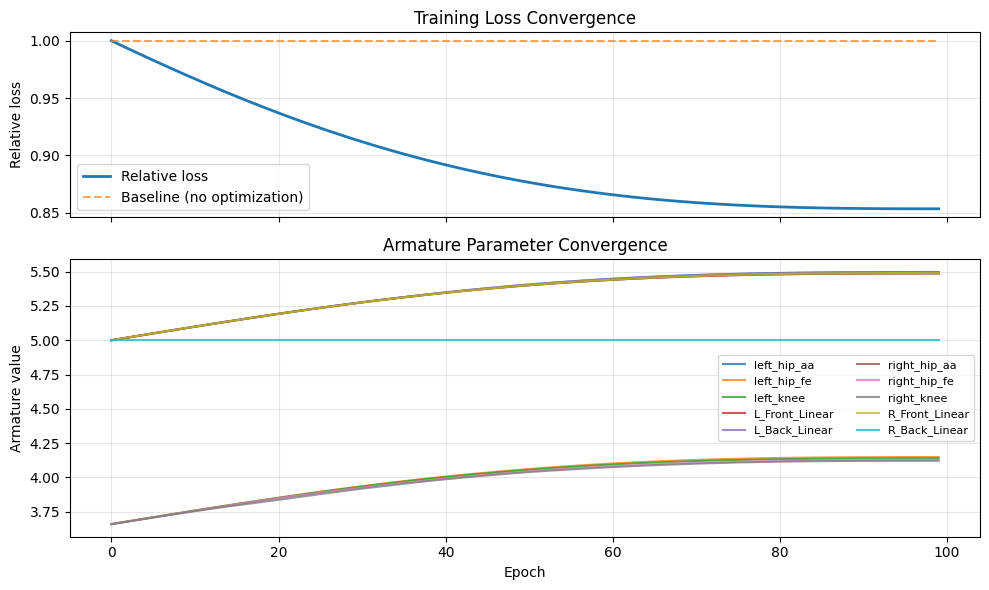

In [13]:
import matplotlib.pyplot as plt
import os, joblib

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 6), gridspec_kw={"height_ratios": [1, 1.5]}, sharex=True
)

# Plot loss convergence
ax1.plot(adjusted_model_loss / baseline_loss, label="Relative loss", linewidth=2)
ax1.plot(base_line, '--', label="Baseline (no optimization)", alpha=0.7)
ax1.set_title("Training Loss Convergence")
ax1.set_ylabel("Relative loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot armature parameter convergence for each joint
for i, joint in enumerate(JOINT_NAMES):
    values = [p["armature"][i] for p in params_hist]
    ax2.plot(values, label=joint, alpha=0.8)
ax2.set_title("Armature Parameter Convergence")
ax2.set_ylabel("Armature value")
ax2.set_xlabel("Epoch")
ax2.legend(fontsize=8, loc='best', ncol=2)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save results
folder_path = os.path.join("exo_experiments", PARAMS.EXPERIMENT_NAME)
os.makedirs(folder_path, exist_ok=True)
img_path = os.path.join(folder_path, "pictures")
os.makedirs(img_path, exist_ok=True)

joblib.dump(
    {
        "params": params_hist,
        "loss_hist": adjusted_model_loss,
        "baseline_loss": baseline_loss,
        "joint_names": JOINT_NAMES,
    },
    os.path.join(folder_path, "optimization_results.joblib"),
)

fig.savefig(
    os.path.join(img_path, "armature_optimization.png"),
    format="png",
    bbox_inches="tight",
    dpi=300
)

print(f"\nFinal optimized armature values:")
for i, joint in enumerate(JOINT_NAMES):
    print(f"  {joint}: {state.params['armature'][i]:.4f}")


### Damping Plot


Final optimized damping values:
  left_hip_aa: 5.4964
  left_hip_fe: 2.4882
  left_knee: 2.4761
  L_Front_Linear: 5.4869
  L_Back_Linear: 5.4841
  right_hip_aa: 5.4866
  right_hip_fe: 2.4616
  right_knee: 2.4404
  R_Front_Linear: 5.4854
  R_Back_Linear: 5.0000


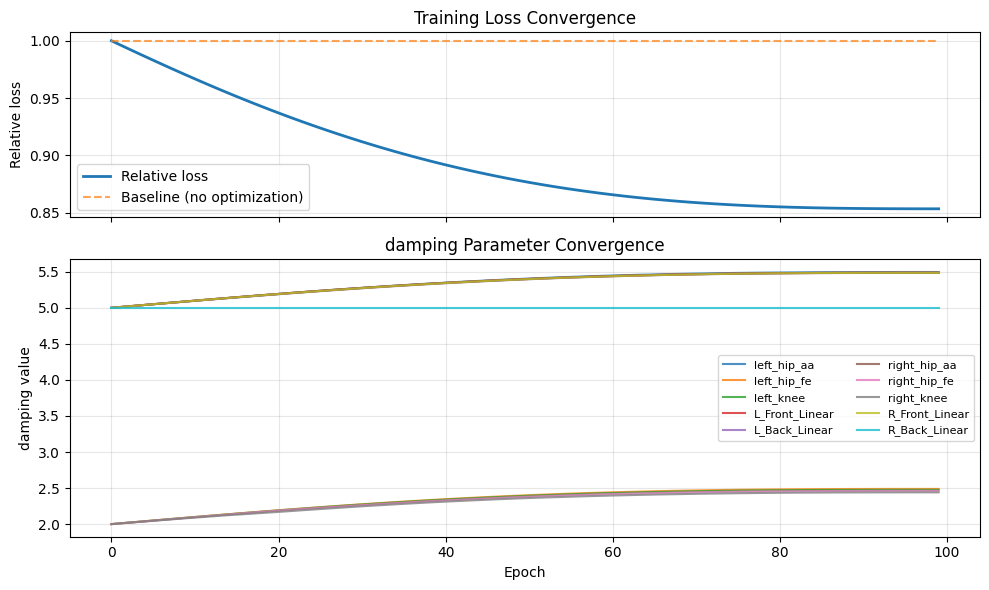

In [14]:
# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 6), gridspec_kw={"height_ratios": [1, 1.5]}, sharex=True
)

# Plot loss convergence
ax1.plot(adjusted_model_loss / baseline_loss, label="Relative loss", linewidth=2)
ax1.plot(base_line, '--', label="Baseline (no optimization)", alpha=0.7)
ax1.set_title("Training Loss Convergence")
ax1.set_ylabel("Relative loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot damping parameter convergence for each joint
for i, joint in enumerate(JOINT_NAMES):
    values = [p["damping"][i] for p in params_hist]
    ax2.plot(values, label=joint, alpha=0.8)
ax2.set_title("damping Parameter Convergence")
ax2.set_ylabel("damping value")
ax2.set_xlabel("Epoch")
ax2.legend(fontsize=8, loc='best', ncol=2)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save results
folder_path = os.path.join("exo_experiments", PARAMS.EXPERIMENT_NAME)
os.makedirs(folder_path, exist_ok=True)
img_path = os.path.join(folder_path, "pictures")
os.makedirs(img_path, exist_ok=True)

joblib.dump(
    {
        "params": params_hist,
        "loss_hist": adjusted_model_loss,
        "baseline_loss": baseline_loss,
        "joint_names": JOINT_NAMES,
    },
    os.path.join(folder_path, "optimization_results.joblib"),
)

fig.savefig(
    os.path.join(img_path, "damping_optimization.png"),
    format="png",
    bbox_inches="tight",
    dpi=300
)

print(f"\nFinal optimized damping values:")
for i, joint in enumerate(JOINT_NAMES):
    print(f"  {joint}: {state.params['damping'][i]:.4f}")


### Friction Loss plot



Final optimized frictionloss values:
  left_hip_aa: 10.0000
  left_hip_fe: 10.0000
  left_knee: 10.0000
  L_Front_Linear: 10.0000
  L_Back_Linear: 10.0000
  right_hip_aa: 10.0000
  right_hip_fe: 10.0000
  right_knee: 10.0000
  R_Front_Linear: 10.0000
  R_Back_Linear: 10.0000


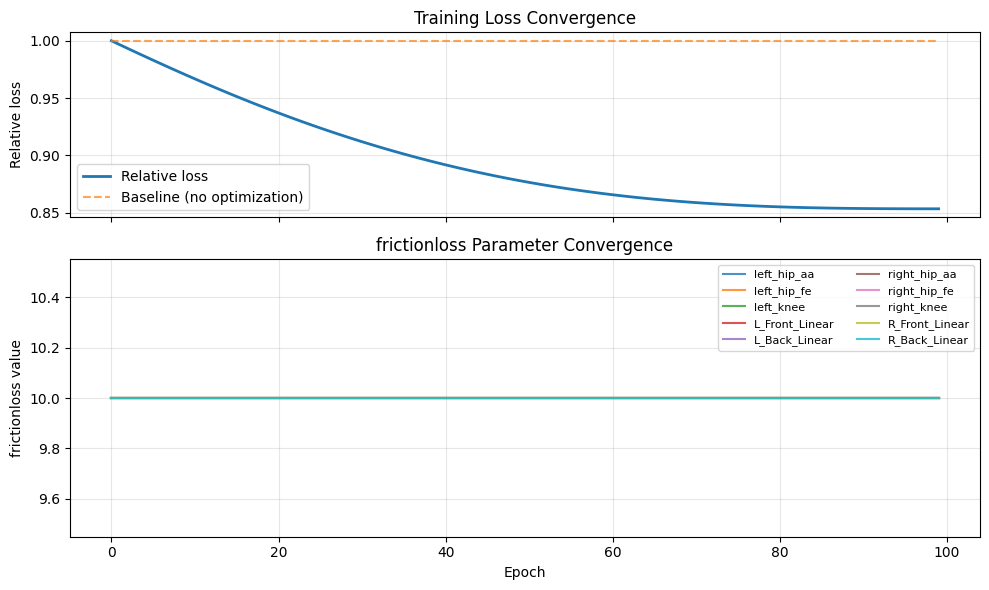

In [15]:
# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 6), gridspec_kw={"height_ratios": [1, 1.5]}, sharex=True
)

# Plot loss convergence
ax1.plot(adjusted_model_loss / baseline_loss, label="Relative loss", linewidth=2)
ax1.plot(base_line, '--', label="Baseline (no optimization)", alpha=0.7)
ax1.set_title("Training Loss Convergence")
ax1.set_ylabel("Relative loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot frictionloss parameter convergence for each joint
for i, joint in enumerate(JOINT_NAMES):
    values = [p["frictionloss"][i] for p in params_hist]
    ax2.plot(values, label=joint, alpha=0.8)
ax2.set_title("frictionloss Parameter Convergence")
ax2.set_ylabel("frictionloss value")
ax2.set_xlabel("Epoch")
ax2.legend(fontsize=8, loc='best', ncol=2)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save results
folder_path = os.path.join("exo_experiments", PARAMS.EXPERIMENT_NAME)
os.makedirs(folder_path, exist_ok=True)
img_path = os.path.join(folder_path, "pictures")
os.makedirs(img_path, exist_ok=True)

joblib.dump(
    {
        "params": params_hist,
        "loss_hist": adjusted_model_loss,
        "baseline_loss": baseline_loss,
        "joint_names": JOINT_NAMES,
    },
    os.path.join(folder_path, "optimization_results.joblib"),
)

fig.savefig(
    os.path.join(img_path, "frictionloss_optimization.png"),
    format="png",
    bbox_inches="tight",
    dpi=300
)

print(f"\nFinal optimized frictionloss values:")
for i, joint in enumerate(JOINT_NAMES):
    print(f"  {joint}: {state.params['frictionloss'][i]:.4f}")


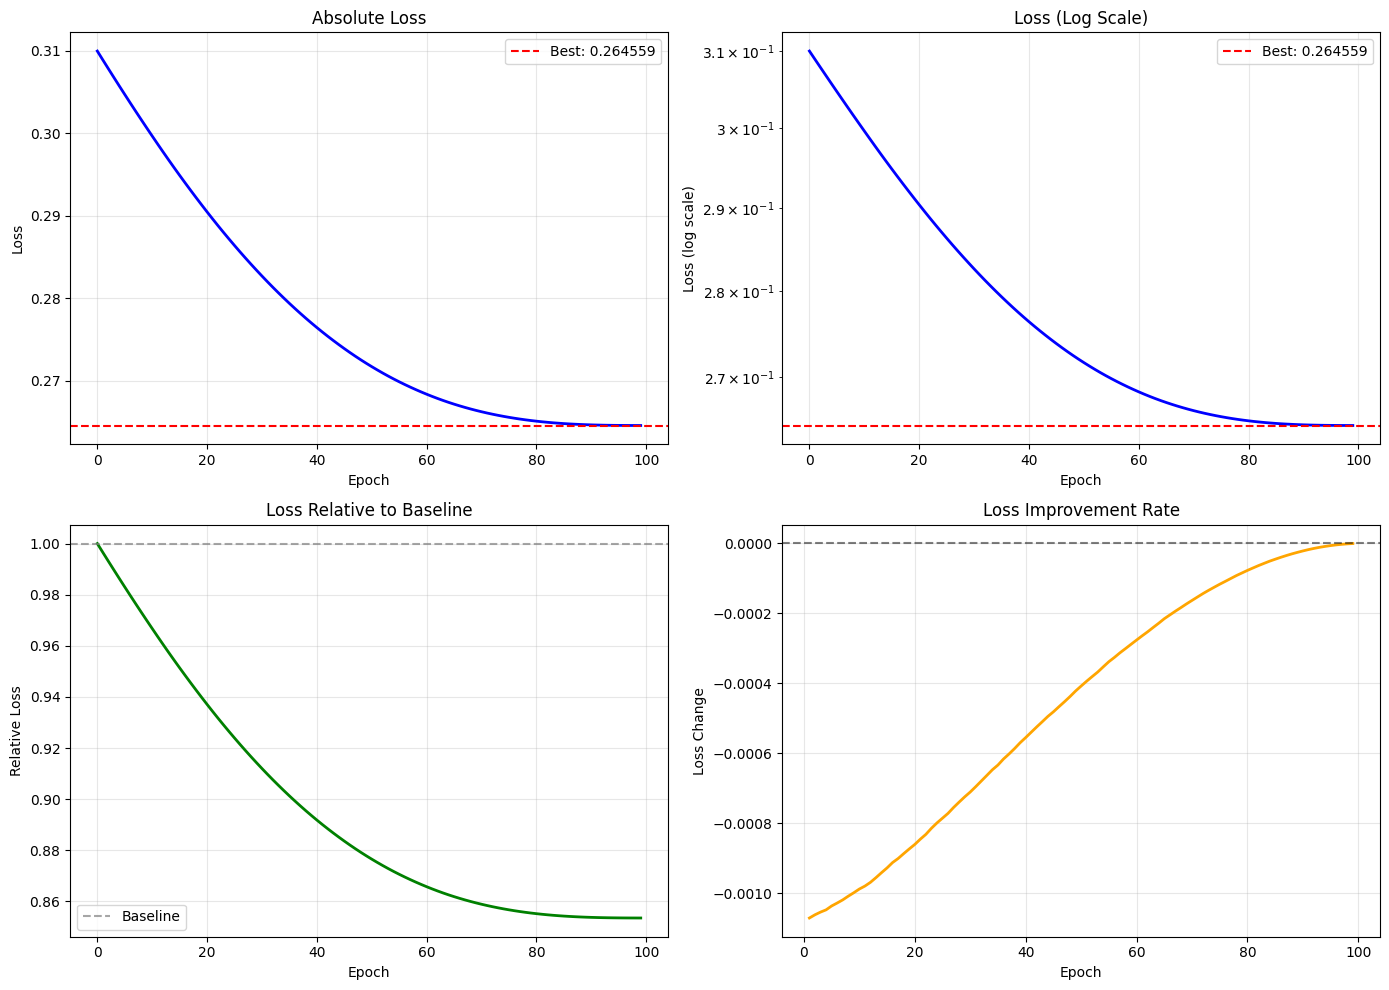


=== COST FUNCTION SUMMARY ===
Initial loss: 0.309957
Final loss: 0.264559
Best loss: 0.264559
Baseline loss: 0.309957
Improvement: 14.6%
Relative to baseline: 0.8535


In [16]:
# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs = np.arange(len(loss_hist))

# 1. Absolute loss
axes[0, 0].plot(epochs, loss_hist, linewidth=2, color='blue')
axes[0, 0].axhline(y=best_loss, color='red', linestyle='--', label=f'Best: {best_loss:.6f}')
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].set_title("Absolute Loss")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Log scale loss
axes[0, 1].plot(epochs, loss_hist, linewidth=2, color='blue')
axes[0, 1].axhline(y=best_loss, color='red', linestyle='--', label=f'Best: {best_loss:.6f}')
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss (log scale)")
axes[0, 1].set_title("Loss (Log Scale)")
axes[0, 1].set_yscale('log')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Relative to baseline
relative_loss = np.array(loss_hist) / baseline_loss
axes[1, 0].plot(epochs, relative_loss, linewidth=2, color='green')
axes[1, 0].axhline(y=1.0, color='gray', linestyle='--', label='Baseline', alpha=0.7)
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Relative Loss")
axes[1, 0].set_title("Loss Relative to Baseline")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Loss improvement rate (derivative)
if len(loss_hist) > 1:
    loss_diff = np.diff(loss_hist)
    axes[1, 1].plot(epochs[1:], loss_diff, linewidth=2, color='orange')
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("Loss Change")
    axes[1, 1].set_title("Loss Improvement Rate")
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()

# Save the figure
folder_path = os.path.join("exo_experiments", PARAMS.EXPERIMENT_NAME)
img_path = os.path.join(folder_path, "pictures")
os.makedirs(img_path, exist_ok=True)

fig.savefig(
    os.path.join(img_path, "cost_function_analysis.png"),
    format="png",
    bbox_inches="tight",
    dpi=300
)

plt.show()

# Print summary
print(f"\n=== COST FUNCTION SUMMARY ===")
print(f"Initial loss: {loss_hist[0]:.6f}")
print(f"Final loss: {loss_hist[-1]:.6f}")
print(f"Best loss: {best_loss:.6f}")
print(f"Baseline loss: {baseline_loss:.6f}")
print(f"Improvement: {(loss_hist[0] - best_loss) / loss_hist[0] * 100:.1f}%")
print(f"Relative to baseline: {best_loss / baseline_loss:.4f}")

In [17]:
print("\n=== FRICTIONLOSS GRADIENT TEST ===")
test_params_friction = {**init_params, "frictionloss": init_params["frictionloss"] * 100}

loss_normal, grad_normal = value_and_grad(init_params, dataset['qpos'][:10], dataset['qvel'][:10], 
                                          dataset['qact'][:10], dataset['qpos_next'][:10], dataset['qvel_next'][:10])
loss_high_fric, grad_high_fric = value_and_grad(test_params_friction, dataset['qpos'][:10], dataset['qvel'][:10],
                                                  dataset['qact'][:10], dataset['qpos_next'][:10], dataset['qvel_next'][:10])

print(f"Loss with normal friction: {loss_normal:.10f}")
print(f"Loss with 100x friction:   {loss_high_fric:.10f}")
print(f"Difference: {abs(loss_normal - loss_high_fric):.10f}")

if abs(loss_normal - loss_high_fric) < 1e-8:
    print("❌ CONFIRMED: Frictionloss has NO effect on loss!")
    print("   → Remove it from optimization")
else:
    print("✅ Frictionloss DOES affect loss")
    print("   → Try increasing TRAJECTORY_LENGTH")


=== FRICTIONLOSS GRADIENT TEST ===
Loss with normal friction: 0.3294824673
Loss with 100x friction:   810000.3294824673
Difference: 810000.0000000000
✅ Frictionloss DOES affect loss
   → Try increasing TRAJECTORY_LENGTH


In [18]:
# Add diagnostic to check if joints are actually moving
print("\n=== VELOCITY ANALYSIS ===")
for i, joint in enumerate(JOINT_NAMES):
    vel_values = dataset['qvel'][:, ACTUATED_QVEL_IDX[i]]
    print(f"{joint}:")
    print(f"  Mean |vel|: {jnp.mean(jnp.abs(vel_values)):.6f}")
    print(f"  Max |vel|:  {jnp.max(jnp.abs(vel_values)):.6f}")
    print(f"  % at rest:  {100 * jnp.mean(jnp.abs(vel_values) < 0.001):.1f}%")


=== VELOCITY ANALYSIS ===
left_hip_aa:
  Mean |vel|: 0.074697
  Max |vel|:  0.339602
  % at rest:  42.1%
left_hip_fe:
  Mean |vel|: 0.076094
  Max |vel|:  0.439026
  % at rest:  34.0%
left_knee:
  Mean |vel|: 0.121363
  Max |vel|:  0.700543
  % at rest:  39.8%
L_Front_Linear:
  Mean |vel|: 0.000132
  Max |vel|:  0.001245
  % at rest:  97.2%
L_Back_Linear:
  Mean |vel|: 0.000000
  Max |vel|:  0.000000
  % at rest:  100.0%
right_hip_aa:
  Mean |vel|: 0.000137
  Max |vel|:  0.001239
  % at rest:  97.5%
right_hip_fe:
  Mean |vel|: 0.000000
  Max |vel|:  0.000000
  % at rest:  100.0%
right_knee:
  Mean |vel|: 0.000000
  Max |vel|:  0.000000
  % at rest:  100.0%
R_Front_Linear:
  Mean |vel|: 0.000000
  Max |vel|:  0.000000
  % at rest:  100.0%
R_Back_Linear:
  Mean |vel|: 0.000000
  Max |vel|:  0.000000
  % at rest:  100.0%
